MERRA2 US Gound Skin Temperature December 2020 (only one file of many shown here)
Region: -125.42, 24.785, -66.709, 49.922

-each file is one day (UTC 11:30 to 23:30)
Date is in the file name e.g. 
MERRA2_400.tavg1_2d_slv_Nx.20201231.SUB.nc
is 2020-12-31

Data from:
https://disc.gsfc.nasa.gov/datasets/M2T1NXSLV_5.12.4/summary 

TS (temperature) is a list of lists of lists
outer: 13 lists one for each time
next: 50 lists one for each lat
inner: 95 temperatures one for each lon
     
Current code converts to pandas df, breaks into time zones, subsets to school hours only and aggregates


In [1]:
import pandas as pd
import xarray as xr
import datetime
import os

In [2]:
from netCDF4 import Dataset #no longer needed?
import numpy as np
#import netCDF4

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

#pd.set_option('mode.chained_assignment', None) # ignore the SettingWithCopy Warning (add column for local time in parse_temperature())


In [9]:
os.listdir()

['.DS_Store',
 'LICENSE',
 'Read_MERRA2.ipynb',
 'README.md',
 'MERRA2_data',
 '.ipynb_checkpoints',
 '.git']

First Function will: 
Take netCDF data (one day subsetted by GES DISC)
Output a pandas df with average daily temperature, daily minimum, hours below freezing and dummy for ever below freezing that day all in the time range of (local time) 8:30AM-3:30PM

In [573]:
#Global Variables
data_folder = 'MERRA2_data'
data = os.listdir(data_folder) #some object to pass in the filenames

# thinking I'll restructure this to be a df with ea time zone as a row and cols:
# lon_west_boundry, lon_east_boundry, utc_time_delta
pacific_lon = [-125, -114] #ish
mountain_lon = [-114, -102] #ish
central_lon = [-102, -85.5] #ish
eastern_lon = [-85.5, -65] #ish
time_deltas = {'pacific': 8, 'mountain':7, 'central':6, 'eastern':5}

In [595]:
def parse_temperature(filename, time_zone_lons, time_delta):
    file = os.path.join(data_folder, filename)
    date = file[-15:-11]+"-"+file[-11:-9]+"-"+file[-9:-7]
    print(date) # debug
    
    # read in netcdf data
    # https://stackoverflow.com/questions/14035148/import-netcdf-file-to-pandas-dataframe
    nc_data = xr.open_dataset(file)
    df = nc_data.to_dataframe()
    df = df.reset_index()
    
    # subset to one time zone
    time_zone_df = df[(df["lon"]>= time_zone_lons[0]) & (df["lon"]< time_zone_lons[1])]
    
    # add local time 
    # throws a warning (both ways shown here)
    #time_zone_df['local_time'] = time_zone_df['time'] - datetime.timedelta(hours=time_delta)
    time_zone_df['local_time'] = time_zone_df['time'].apply(lambda x: x - datetime.timedelta(hours=time_delta))
    
    
    #subset to school-hrs only (8:30AM-3:30PM)
    school_str = pd.to_datetime('{} 8:30:00'.format(date))
    school_end = pd.to_datetime('{} 15:30:00'.format(date)) 

    time_zone_df = time_zone_df[(time_zone_df["local_time"]>= school_str) & 
                                (time_zone_df["local_time"]<= school_end)]
    
    # add dummy for hr below freezing
    time_zone_df['below_freezing'] = time_zone_df['TS'].apply(lambda x: 1 if x <= 273.15 else 0)
    
    # check before aggrogate
    assert time_zone_df.iloc[12]['local_time'] == pd.to_datetime('{} 12:30:00'.format(date))
    assert time_zone_df['TS'].min() > 216.5 # a bit warmer than -70F (record low in US excluding Alaska)
    assert time_zone_df['TS'].max() < 330 # a bit colder than 134F (recod high in US)
    
    # aggrogate by location (get daily average temp, daily min and count of hrs belwo freezing)
    # https://www.statology.org/pandas-groupby-aggregate-multiple-columns/

    #return time_zone_df # debug
       
    tz_grouped = time_zone_df.groupby(['lat', 'lon']).agg({'TS': ['mean', 'min'], 
                                                          'below_freezing': 'sum'})
    tz_grouped.columns = ['average_temp', 'min_daily_temp', 'hrs_below_freezing']
    
    tz_final = tz_grouped.reset_index()
    
    # add  dummy for if the day dropped below freezing at any time(hr)
    tz_final['day_below_freezing'] = tz_final['hrs_below_freezing'].apply(lambda x: 1 if x >= 1 else 0)
    tz_final['day_below_freezing'] = tz_final['day_below_freezing'].astype(int)
    #print(tz_final.shape)
    
    return tz_final

In [575]:
# will want a way to run these more sucinctly
def get_one_day(filename):
    pst = parse_temperature(filename, pacific_lon, time_deltas['pacific'])
    mst = parse_temperature(filename, mountain_lon, time_deltas['mountain'])
    cst = parse_temperature(filename, central_lon, time_deltas['central'])
    est = parse_temperature(filename, eastern_lon, time_deltas['eastern'])
    
    conc_df = pd.concat([pst, mst, cst, est], ignore_index=True)
    
    return conc_df


In [596]:
#conc_df = pd.concat([pst, mst, cst, est], ignore_index=True)
conc_df = get_one_day(filename)
conc_df.head()

2020-12-03
2020-12-03
2020-12-03
2020-12-03


,lat,lon,average_temp,min_daily_temp,hrs_below_freezing,day_below_freezing
0,25.0,-125.000,294.845825,294.839630,0,0
1,25.0,-124.375,294.677856,294.674316,0,0
2,25.0,-123.750,294.518677,294.511505,0,0
3,25.0,-123.125,294.583130,294.574005,0,0
4,25.0,-122.500,294.842896,294.835571,0,0


In [605]:
conc_df['hrs_below_freezing']

0       0
1       0
2       0
3       0
4       0
       ..
4695    8
4696    8
4697    8
4698    8
4699    0
Name: hrs_below_freezing, Length: 4700, dtype: int64

Next:
1) Itterate over each day
2) Concat
3) Aggregate

In [598]:
month_df = pd.DataFrame(columns=['lat', 'lon', 'average_temp', 'min_daily_temp', 
                                 'hrs_below_freezing', 'day_below_freezing'])

In [599]:
for file in data:
    if file.endswith('.nc'):
        conc_df = get_one_day(file)
        month_df = pd.concat([month_df, conc_df], ignore_index=True)

2020-12-24
2020-12-24
2020-12-24
2020-12-24
2020-12-28
2020-12-28
2020-12-28
2020-12-28
2020-12-12
2020-12-12
2020-12-12
2020-12-12
2020-12-26
2020-12-26
2020-12-26
2020-12-26
2020-12-10
2020-12-10
2020-12-10
2020-12-10
2020-12-02
2020-12-02
2020-12-02
2020-12-02
2020-12-06
2020-12-06
2020-12-06
2020-12-06
2020-12-18
2020-12-18
2020-12-18
2020-12-18
2020-12-14
2020-12-14
2020-12-14
2020-12-14
2020-12-22
2020-12-22
2020-12-22
2020-12-22
2020-12-30
2020-12-30
2020-12-30
2020-12-30
2020-12-08
2020-12-08
2020-12-08
2020-12-08
2020-12-16
2020-12-16
2020-12-16
2020-12-16
2020-12-04
2020-12-04
2020-12-04
2020-12-04
2020-12-20
2020-12-20
2020-12-20
2020-12-20
2020-12-01
2020-12-01
2020-12-01
2020-12-01
2020-12-13
2020-12-13
2020-12-13
2020-12-13
2020-12-25
2020-12-25
2020-12-25
2020-12-25
2020-12-29
2020-12-29
2020-12-29
2020-12-29
2020-12-11
2020-12-11
2020-12-11
2020-12-11
2020-12-03
2020-12-03
2020-12-03
2020-12-03
2020-12-27
2020-12-27
2020-12-27
2020-12-27
2020-12-23
2020-12-23
2020-12-23

In [603]:
month_df.dtypes

lat                   float64
lon                   float64
average_temp          float32
min_daily_temp        float32
hrs_below_freezing     object
day_below_freezing     object
dtype: object

In [606]:
# Aggrogate month
# haveing an issue wiht dtype of hrs_belwo_freezing and day_beow_freezing
# so excluding for now

month_grouped = month_df.groupby(['lat', 'lon']).agg({'average_temp': 'mean',
                                                      'min_daily_temp': ['mean', 'min']})
                                                      #'hrs_below_freezing': ['mean','sum'],
                                                      #'day_below_freezing': 'sum'})

#month_grouped.head()
month_grouped.columns = ['average_temp', 'average_min_daily_temp', 'min_min_daily_temp']
    
month_final = month_grouped.reset_index()
    

In [607]:
month_final.head()

,lat,lon,average_temp,average_min_daily_temp,min_min_daily_temp
0,25.0,-125.000,294.203278,294.185822,293.549683
1,25.0,-124.375,294.123444,294.106689,293.596558
2,25.0,-123.750,293.986938,293.971741,293.416870
3,25.0,-123.125,293.982330,293.970184,293.346558
4,25.0,-122.500,294.092590,294.080139,293.401245


In [608]:
month_final.to_csv('{} temperature.csv'.format(date[0:7]))

### Notes and Loose Code

https://disc.gsfc.nasa.gov/datasets/M2T1NXSLV_5.12.4/summary 
Dataset: MERRA-2 tavg1_2d_slv_Nx: 2d,1-Hourly,Time-Averaged,Single-Level,Assimilation,Single-Level Diagnostics V5.12.4
Download Method: Get File Subsets using the GES DISC Subsetter
Date Range: 2020-12-01 to 2020-12-31
Region: -125.244, 24.961, -67.061, 49.395 (Search and Crop)
Time of Day: 11:30 to 23:30
Variables:
TS = surface skin temperature
U2M = 2-meter eastward wind
V2M = 2-meter northward wind
Format: netCDF


ws = np.sqrt(U2M_nans**2+V2M_nans**2)

https://stackoverflow.com/questions/14035148/import-netcdf-file-to-pandas-dataframe
import xarray as xr

ds = xr.open_dataset('/path/to/netcdf')
df = ds.to_dataframe()

In [21]:
data_folder = 'test_MERRA2_data'
filename = 'MERRA2_400.tavg1_2d_slv_Nx.20201201.SUB.nc'
file = os.path.join(data_folder, filename)
date = file[-15:-11]+"-"+file[-11:-9]+"-"+file[-9:-7]

pacific_lon = [-125, -114] #ish
mountain_lon = [-114, -102] #ish
central_lon = [-102, -85.5] #ish
eastern_lon = [-85.5, -65] #ish
time_deltas = {'pacific': 8, 'mountain':7, 'central':6, 'eastern':5}

In [22]:
nc_data = xr.open_dataset(file)
nc_data

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 93, time: 13)
Coordinates:
  * time     (time) datetime64[ns] 2020-12-01T11:30:00 ... 2020-12-01T23:30:00
  * lon      (lon) float64 -125.0 -124.4 -123.8 -123.1 ... -68.75 -68.12 -67.5
  * lat      (lat) float64 25.0 25.5 26.0 26.5 27.0 ... 47.0 47.5 48.0 48.5 49.0
Data variables:
    TS       (time, lat, lon) float32 ...
    U2M      (time, lat, lon) float32 ...
    V2M      (time, lat, lon) float32 ...
Attributes:
    CDI:                               Climate Data Interface version 1.9.8 (...
    Conventions:                       CF-1
    History:                           Original file generated: Wed Dec 16 23...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Filename:                          MERRA2_400.tavg1_2d_slv_Nx.20201201.nc4
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    Format:                            NetCDF-4/HDF-5
    SpatialCoverage:                   global
    VersionID:                         5.12.4
    TemporalRange:                     1980-01-01 -> 2016-12-31
    identifier_product_doi_authority:  http://dx.doi.org/
    ShortName:                         M2T1NXSLV
    GranuleID:                         MERRA2_400.tavg1_2d_slv_Nx.20201201.nc4
    ProductionDateTime:                Original file generated: Wed Dec 16 23...
    LongName:                          MERRA2 tavg1_2d_slv_Nx: 2d,1-Hourly,Ti...
    Title:                             MERRA2 tavg1_2d_slv_Nx: 2d,1-Hourly,Ti...
    SouthernmostLatitude:              -90.0
    NorthernmostLatitude:              90.0
    WesternmostLongitude:              -180.0
    EasternmostLongitude:              179.375
    LatitudeResolution:                0.5
    LongitudeResolution:               0.625
    DataResolution:                    0.5 x 0.625
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/VJAFPLI1CSIV
    RangeBeginningDate:                2020-12-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2020-12-01
    RangeEndingTime:                   23:59:59.000000
    history_L34RS:                     'Created by L34RS v1.4.1 @ NASA GES DI...
    CDO:                               Climate Data Operators version 1.9.8 (...

In [23]:
df = nc_data.to_dataframe()

In [24]:
df.iloc[12]

TS     295.003876
U2M     -3.253437
V2M     -4.694278
Name: (25.0, -125.0, 2020-12-01 23:30:00), dtype: float32

In [25]:
df = df.reset_index()

In [26]:
df.head()

,lat,lon,time,TS,U2M,V2M
0,25.0,-125.0,2020-12-01 11:30:00,295.057617,-3.111600,-5.607658
1,25.0,-125.0,2020-12-01 12:30:00,295.052429,-3.013288,-5.700332
2,25.0,-125.0,2020-12-01 13:30:00,295.047150,-3.006176,-5.765806
3,25.0,-125.0,2020-12-01 14:30:00,295.046356,-3.072954,-5.795807
4,25.0,-125.0,2020-12-01 15:30:00,295.041718,-3.198376,-5.784239


### Divide into Time Zone

In [40]:
pst_df = df[(df["lon"]>= pacific_lon[0]) & (df["lon"]< pacific_lon[1])]
pst_df.head()

,lat,lon,time,TS,U2M,V2M
0,25.0,-125.0,2020-12-01 11:30:00,295.057617,-3.111600,-5.607658
1,25.0,-125.0,2020-12-01 12:30:00,295.052429,-3.013288,-5.700332
2,25.0,-125.0,2020-12-01 13:30:00,295.047150,-3.006176,-5.765806
3,25.0,-125.0,2020-12-01 14:30:00,295.046356,-3.072954,-5.795807
4,25.0,-125.0,2020-12-01 15:30:00,295.041718,-3.198376,-5.784239


In [56]:
def time_zone_df(df, lons):
    '''takes the temperature pandas df and a list of 2 longitues to bound the region
    output is a subset of the df within those bounds
    '''
    time_zone_df = df[(df["lon"]>= lons[0]) & (df["lon"]< lons[1])]
    return time_zone_df   

In [79]:
#check
pst_df = time_zone_df(df, pacific_lon)

In [80]:
pst_df['lon'].unique()

array([-125.   , -124.375, -123.75 , -123.125, -122.5  , -121.875,
       -121.25 , -120.625, -120.   , -119.375, -118.75 , -118.125,
       -117.5  , -116.875, -116.25 , -115.625, -115.   , -114.375])

### Add local time col

In [81]:
pst_df['local_time'] = pst_df['time'] - datetime.timedelta(hours=5)

/Users/Sarah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [82]:
pst_df['local_time'].head()

0   2020-12-01 06:30:00
1   2020-12-01 07:30:00
2   2020-12-01 08:30:00
3   2020-12-01 09:30:00
4   2020-12-01 10:30:00
Name: local_time, dtype: datetime64[ns]

In [83]:
school_str = pd.to_datetime('{} 8:30:00'.format(date))
school_end = pd.to_datetime('{} 15:30:00'.format(date)) #only have data up till 15:30 for PST
#(pst_df["local_time"] <= school_end).tail()
#(pst_df["local_time"] >= school_str).tail()
pst_df = pst_df[(pst_df["local_time"]>= school_str) & 
                (pst_df["local_time"]<= school_end)]

#df.loc[(pst_df["local_time"] > start_date) & (df['datetime_col'] < end_date)]
#

In [84]:
pst_df.iloc[12]['local_time']
assert pst_df.iloc[12]['local_time'] == pd.to_datetime('{} 12:30:00'.format(date))

In [85]:
#assert pst_df['TS'].apply(lambda x: x > 0)
assert pst_df['TS'].min() > 216.5 # a bit warmer than -70F (record low in US excluding Alaska)
assert pst_df['TS'].max() < 330 # a bit colder than 134F (recod high in US)

In [559]:
'''for i, v in enumerate(pst_df['TS']):
    if not v > 216.5:
        print(i, v)'''

In [86]:
pst_df.columns

Index(['lat', 'lon', 'time', 'TS', 'U2M', 'V2M', 'local_time'], dtype='object')

## Add windspeed
https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20calculate%20and%20plot%20wind%20speed%20using%20MERRA-2%20wind%20component%20data%20using%20Python#!
ws = np.sqrt(U2M_nans**2+V2M_nans**2)

In [87]:
#pst_df['local_time'] = pst_df['time'] - datetime.timedelta(hours=8)
pst_df['wind_speed (mph)'] = np.sqrt(pst_df['U2M']**2+pst_df['V2M']**2)*(2.236942)
pst_df.head()

,lat,lon,time,TS,U2M,V2M,local_time,wind_speed (mph)
2,25.0,-125.0,2020-12-01 13:30:00,295.047150,-3.006176,-5.765806,2020-12-01 08:30:00,14.545562
3,25.0,-125.0,2020-12-01 14:30:00,295.046356,-3.072954,-5.795807,2020-12-01 09:30:00,14.674480
4,25.0,-125.0,2020-12-01 15:30:00,295.041718,-3.198376,-5.784239,2020-12-01 10:30:00,14.785329
5,25.0,-125.0,2020-12-01 16:30:00,295.037292,-3.341337,-5.722026,2020-12-01 11:30:00,14.822356
6,25.0,-125.0,2020-12-01 17:30:00,295.032715,-3.438481,-5.593594,2020-12-01 12:30:00,14.687606


## Add F temp

In [88]:
#F = (K - 273.15)* 1.8000 + 32.00

pst_df['Temperature (F)'] = (pst_df['TS'] - 273.15)* 1.8000 + 32.00
pst_df.head()

,lat,lon,time,TS,U2M,V2M,local_time,wind_speed (mph),Temperature (F)
2,25.0,-125.0,2020-12-01 13:30:00,295.047150,-3.006176,-5.765806,2020-12-01 08:30:00,14.545562,71.414879
3,25.0,-125.0,2020-12-01 14:30:00,295.046356,-3.072954,-5.795807,2020-12-01 09:30:00,14.674480,71.413452
4,25.0,-125.0,2020-12-01 15:30:00,295.041718,-3.198376,-5.784239,2020-12-01 10:30:00,14.785329,71.405106
5,25.0,-125.0,2020-12-01 16:30:00,295.037292,-3.341337,-5.722026,2020-12-01 11:30:00,14.822356,71.397141
6,25.0,-125.0,2020-12-01 17:30:00,295.032715,-3.438481,-5.593594,2020-12-01 12:30:00,14.687606,71.388901


## Add Windchill
For below 50F and above 3mph only!?!?
If using ºF and mph: Wind chill temperature = 35.74 + 0.6215T - 35.75V^0.16 + 0.4275TV^0.16

When temperatures are below 50F and wind is above 3mph windchill is calculated     
Othewise, temperatreu F is substituted for windchill

In [89]:
#pst_df['TS'].apply(lambda x: 1 if x <= 273.15 else 0)

    
    
pst_df['Windchill (F)'] = np.where((pst_df['Temperature (F)']<= 50) & (pst_df['wind_speed (mph)']>=3), 
                        (35.74 
                        + 0.6215*pst_df['Temperature (F)'] 
                        - 35.75*pst_df['wind_speed (mph)']**0.16
                        + 0.4275*pst_df['Temperature (F)']*pst_df['wind_speed (mph)']**0.16),
                        pst_df['Temperature (F)'])
pst_df.head()

,lat,lon,time,TS,U2M,V2M,local_time,wind_speed (mph),Temperature (F),Windchill (F)
2,25.0,-125.0,2020-12-01 13:30:00,295.047150,-3.006176,-5.765806,2020-12-01 08:30:00,14.545562,71.414879,71.414879
3,25.0,-125.0,2020-12-01 14:30:00,295.046356,-3.072954,-5.795807,2020-12-01 09:30:00,14.674480,71.413452,71.413452
4,25.0,-125.0,2020-12-01 15:30:00,295.041718,-3.198376,-5.784239,2020-12-01 10:30:00,14.785329,71.405106,71.405106
5,25.0,-125.0,2020-12-01 16:30:00,295.037292,-3.341337,-5.722026,2020-12-01 11:30:00,14.822356,71.397141,71.397141
6,25.0,-125.0,2020-12-01 17:30:00,295.032715,-3.438481,-5.593594,2020-12-01 12:30:00,14.687606,71.388901,71.388901


In [90]:
pst_df.tail()

,lat,lon,time,TS,U2M,V2M,local_time,wind_speed (mph),Temperature (F),Windchill (F)
58258,49.0,-114.375,2020-12-01 16:30:00,251.271667,0.622652,0.401997,2020-12-01 11:30:00,1.657900,-7.380985,-7.380985
58259,49.0,-114.375,2020-12-01 17:30:00,258.442871,0.405757,0.412266,2020-12-01 12:30:00,1.293954,5.527180,5.527180
58260,49.0,-114.375,2020-12-01 18:30:00,264.566986,0.239375,0.181120,2020-12-01 13:30:00,0.671474,16.550587,16.550587
58261,49.0,-114.375,2020-12-01 19:30:00,266.247925,0.179707,0.103679,2020-12-01 14:30:00,0.464099,19.576275,19.576275
58262,49.0,-114.375,2020-12-01 20:30:00,267.104004,0.190560,0.102826,2020-12-01 15:30:00,0.484372,21.117218,21.117218


### Count hours below freezing
0°C = 273.15 k

In [204]:
#pst_df['below_freezing']= 0

In [18]:
#pst_df['below_freezing'].loc[df['TS'] <= 273.15] = 1

pst_df['below_freezing'] = pst_df['TS'].apply(lambda x: 1 if x <= 273.15 else 0)

In [19]:
pst_df['below_freezing'].unique()

array([0, 1])

In [20]:
pst_df['local_time'].unique()

array(['2020-12-01T08:30:00.000000000', '2020-12-01T09:30:00.000000000',
       '2020-12-01T10:30:00.000000000', '2020-12-01T11:30:00.000000000',
       '2020-12-01T12:30:00.000000000', '2020-12-01T13:30:00.000000000',
       '2020-12-01T14:30:00.000000000', '2020-12-01T15:30:00.000000000'],
      dtype='datetime64[ns]')

In [313]:
#https://www.statology.org/pandas-groupby-aggregate-multiple-columns/

pst_grouped = pst_df.groupby(['lat', 'lon']).agg({'TS': ['mean', 'min'], 
                                                  'below_freezing': 'sum'})


In [314]:
pst_grouped.columns

MultiIndex([(            'TS', 'mean'),
            (            'TS',  'min'),
            ('below_freezing',  'sum')],
           )

In [315]:
pst_grouped.columns = ['average_temp', 'min_daily_temp', 'hrs_below_freezing']

In [316]:
pst_grouped.tail()

average_temp  min_daily_temp  hrs_below_freezing
lat  lon                                                       
49.5 -116.875    267.875610      255.956818                   8
     -116.250    268.156616      257.495880                   8
     -115.625    270.648987      264.609161                   6
     -115.000    267.350708      259.124786                   8
     -114.375    270.151733      266.595490                   8

In [326]:
pst_final = pst_grouped.reset_index()
pst_final.head()

,lat,lon,average_temp,min_daily_temp,hrs_below_freezing
0,25.0,-125.000,294.845825,294.839630,0
1,25.0,-124.375,294.677856,294.674316,0
2,25.0,-123.750,294.518677,294.511505,0
3,25.0,-123.125,294.583130,294.574005,0
4,25.0,-122.500,294.842896,294.835571,0


In [331]:
pst_final.tail()

,lat,lon,average_temp,min_daily_temp,hrs_below_freezing
895,49.5,-116.875,267.875610,255.956818,8
896,49.5,-116.250,268.156616,257.495880,8
897,49.5,-115.625,270.648987,264.609161,6
898,49.5,-115.000,267.350708,259.124786,8
899,49.5,-114.375,270.151733,266.595490,8


In [432]:
pst_final['day_below_freezing'] = pst_final['hrs_below_freezing'].apply(lambda x: 1 if x >= 1 else 0)

In [434]:
pst_final.head()

,lat,lon,average_temp,min_daily_temp,hrs_below_freezing,day_below_freezing
0,25.0,-125.000,294.845825,294.839630,0,0
1,25.0,-124.375,294.677856,294.674316,0,0
2,25.0,-123.750,294.518677,294.511505,0,0
3,25.0,-123.125,294.583130,294.574005,0,0
4,25.0,-122.500,294.842896,294.835571,0,0


### Try a quick plot to verify -nope! not working

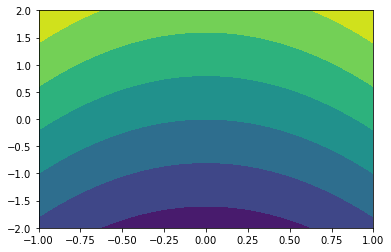

In [398]:
fig = plt.figure()
ax = fig.add_subplot(111)
u = np.linspace(-1,1)
p = np.linspace(-2,2)
x,y = np.meshgrid(u,p)
z = x**2 + y
ax.contourf(x,y,z)
plt.show()

In [399]:
x

array([[-1.        , -0.95918367, -0.91836735, ...,  0.91836735,
         0.95918367,  1.        ],
       [-1.        , -0.95918367, -0.91836735, ...,  0.91836735,
         0.95918367,  1.        ],
       [-1.        , -0.95918367, -0.91836735, ...,  0.91836735,
         0.95918367,  1.        ],
       ...,
       [-1.        , -0.95918367, -0.91836735, ...,  0.91836735,
         0.95918367,  1.        ],
       [-1.        , -0.95918367, -0.91836735, ...,  0.91836735,
         0.95918367,  1.        ],
       [-1.        , -0.95918367, -0.91836735, ...,  0.91836735,
         0.95918367,  1.        ]])

In [351]:
#https://stackoverflow.com/questions/24032282/create-contour-plot-from-pandas-groupby-dataframe
pst_pivot = pst_final.pivot('lon', 'lat')
pst_pivot.head()

average_temp                                                  \
lat              25.0        25.5        26.0        26.5        27.0   
lon                                                                     
-125.000   294.845825  294.596802  294.347778  294.231567  294.161255   
-124.375   294.677856  294.499146  294.096802  293.850708  293.817505   
-123.750   294.518677  294.331177  293.858521  293.569458  293.323364   
-123.125   294.583130  294.359497  293.707153  293.386841  293.057739   
-122.500   294.842896  294.488403  293.796997  293.280396  293.041138   

                                                                      ...  \
lat             27.5        28.0        28.5        29.0        29.5  ...   
lon                                                                   ...   
-125.000  294.003052  293.703247  293.140747  292.519653  292.226685  ...   
-124.375  293.701294  293.662231  293.213013  292.544067  292.073364  ...   
-123.750  293.087036  293.005005  292.869263  292.524536  292.096802  ...   
-123.125  292.904419  292.834106  292.714966  292.459106  291.976685  ...   
-122.500  293.024536  292.868286  292.601685  292.418091  291.924927  ...   

         hrs_below_freezing                                               
lat                    45.0 45.5 46.0 46.5 47.0 47.5 48.0 48.5 49.0 49.5  
lon                                                                       
-125.000                  0    0    0    0    0    0    0    0    0    0  
-124.375                  0    0    0    0    0    0    0    0    0    0  
-123.750                  0    0    0    0    0    0    0    0    0    0  
-123.125                  0    0    0    0    0    1    0    0    0    0  
-122.500                  0    0    0    0    0    0    0    0    0    2  

[5 rows x 150 columns]

In [352]:
X=pst_pivot.columns.levels[1].values
Y=pst_pivot.index.values
Z=pst_pivot.values
Xi,Yi = np.meshgrid(X, Y)

In [408]:
len(Yi[0])

50

In [333]:
lons = pst_final['lon']
lats = pst_final['lat']
lon, lat = np.meshgrid(lons, lats)

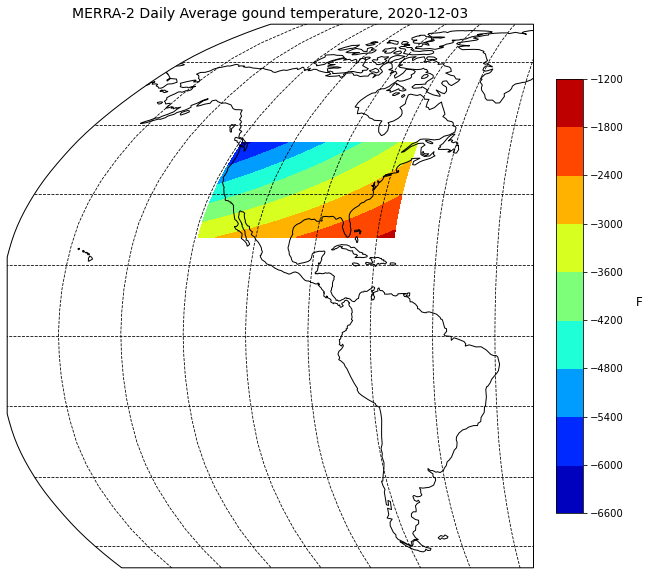

In [421]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_extent([-400,-180,80,300])
#ax.set_global()
    #ax.coastlines(resolution="50m",linewidth=1)
ax.coastlines(resolution="110m",linewidth=1)
ax.gridlines(linestyle='--',color='black')


    # Set contour levels, then draw the plot and a colorbar
    #clevs = np.arange(0,19,1)
plt.contourf(lon, lat, lon*lat, transform=ccrs.PlateCarree(),cmap=plt.cm.jet)
plt.title('MERRA-2 Daily Average gound temperature, {}'.format(date), size=14)
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.set_label('F',size=12,rotation=0,labelpad=15)
cb.ax.tick_params(labelsize=10)

### Daily Min -Out of Date

In [272]:
test = pst_df.groupby(['lat', 'lon']).min()

In [273]:
test.drop(columns = ['time','local_time', 'below_freezing'], inplace = True)

TypeError: 'set' object is not callable

In [280]:
test.columns

Index(['min_daily_temp'], dtype='object')

In [279]:
#test2 = test.rename(columns = {'TS', 'min_daily_temp'})
test.columns = ['min_daily_temp']

In [281]:
test_merge = pd.merge(pst_df, test, left_on = ['lat','lon'], right_index = True)

In [282]:
test_merge

,lat,lon,time,TS,local_time,below_freezing,min_daily_temp
5,25.0,-125.000,2020-12-01 16:30:00,295.037292,2020-12-01 08:30:00,0,295.003876
6,25.0,-125.000,2020-12-01 17:30:00,295.032715,2020-12-01 09:30:00,0,295.003876
7,25.0,-125.000,2020-12-01 18:30:00,295.029877,2020-12-01 10:30:00,0,295.003876
8,25.0,-125.000,2020-12-01 19:30:00,295.021362,2020-12-01 11:30:00,0,295.003876
9,25.0,-125.000,2020-12-01 20:30:00,295.016785,2020-12-01 12:30:00,0,295.003876
...,...,...,...,...,...,...,...
60107,49.5,-114.375,2020-12-01 19:30:00,267.461792,2020-12-01 11:30:00,1,257.853699
60108,49.5,-114.375,2020-12-01 20:30:00,268.446472,2020-12-01 12:30:00,1,257.853699
60109,49.5,-114.375,2020-12-01 21:30:00,268.736053,2020-12-01 13:30:00,1,257.853699
60110,49.5,-114.375,2020-12-01 22:30:00,268.164978,2020-12-01 14:30:00,1,257.853699


### The tutorial way:
Current code is modeled after (copied from) 
GES DISC How Tos: How to calculate and plot wind speed using MERRA-2 wind component data using Python 
https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20calculate%20and%20plot%20wind%20speed%20using%20MERRA-2%20wind%20component%20data%20using%20Python#! 

In [363]:
data = Dataset(file, mode='r')

In [364]:
print(data)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    CDI: Climate Data Interface version 1.9.8 (https://mpimet.mpg.de/cdi)
    Conventions: CF-1
    History: Original file generated: Thu Dec 17 04:51:39 2020 GMT
    Comment: GMAO filename: d5124_m2_jan10.tavg1_2d_slv_Nx.20201203.nc4
    Filename: MERRA2_400.tavg1_2d_slv_Nx.20201203.nc4
    Institution: NASA Global Modeling and Assimilation Office
    References: http://gmao.gsfc.nasa.gov
    Format: NetCDF-4/HDF-5
    SpatialCoverage: global
    VersionID: 5.12.4
    TemporalRange: 1980-01-01 -> 2016-12-31
    identifier_product_doi_authority: http://dx.doi.org/
    ShortName: M2T1NXSLV
    GranuleID: MERRA2_400.tavg1_2d_slv_Nx.20201203.nc4
    ProductionDateTime: Original file generated: Thu Dec 17 04:51:39 2020 GMT
    LongName: MERRA2 tavg1_2d_slv_Nx: 2d,1-Hourly,Time-Averaged,Single-Level,Assimilation,Single-Level Diagnostics
    Title: MERRA2 tavg1_2d_slv_Nx: 2d,1-Hourly,Time-Averaged,Single-Le

/Users/Sarah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  """Entry point for launching an IPython kernel.


In [365]:
print(data.variables.keys())

odict_keys(['time', 'lon', 'lat', 'TS'])


In [366]:
data.variables

OrderedDict([('time',
              <class 'netCDF4._netCDF4.Variable'>
              int32 time(time)
                  standard_name: time
                  long_name: time
                  units: minutes since 2020-12-03 00:30:00
                  calendar: standard
                  axis: T
              unlimited dimensions: time
              current shape = (13,)
              filling off),
             ('lon',
              <class 'netCDF4._netCDF4.Variable'>
              float64 lon(lon)
                  standard_name: longitude
                  long_name: longitude
                  units: degrees_east
                  axis: X
              unlimited dimensions: 
              current shape = (94,)
              filling off),
             ('lat',
              <class 'netCDF4._netCDF4.Variable'>
              float64 lat(lat)
                  standard_name: latitude
                  long_name: latitude
                  units: degrees_north
                  axis: Y
  

In [367]:
lons = data.variables['lon']
lats = data.variables['lat']
lon, lat = np.meshgrid(lons, lats)
temp = data.variables['TS']

In [368]:
temp_nans = temp[:]
_FillValuetemp = temp._FillValue
temp_nans[temp_nans == _FillValuetemp] = np.nan

In [378]:
#F = (K - 273.15)* 1.8000 + 32.00

tempF = (temp_nans - 273.15)* 1.8000 + 32.00

In [379]:
len(data.variables['TS'][0])

50

In [380]:
len(tempF[0][0])

94

In [381]:
lat[0]


masked_array(data=[25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
                   25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
                   25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
                   25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
                   25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
                   25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
                   25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
                   25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
                   25., 25., 25., 25., 25., 25.],
             mask=False,
       fill_value=1e+20)

https://stackoverflow.com/questions/29135885/netcdf4-extract-for-subset-of-lat-lon

lats = f.variables['latitude'][:] 
lons = f.variables['longitude'][:]
lat_bnds, lon_bnds = [40, 43], [-96, -89]

lat_inds = np.where((lats > lat_bnds[0]) & (lats < lat_bnds[1]))
lon_inds = np.where((lons > lon_bnds[0]) & (lons < lon_bnds[1]))

air_subset = f.variables['air'][:,lat_inds,lon_inds]


In [192]:
#lats = data.variables['lat'][:] 
#lons = data.variables['lon'][:]
lat_bnds, lon_bnds = [24.785, 26.000], [-125.42, -66.709]
#lats: 24.785 to 49.922
lat_inds = np.where((lats[:] > lat_bnds[0]) & (lats[:] < lat_bnds[1]))
lon_inds = np.where((lons[:] > lon_bnds[0]) & (lons[:] < lon_bnds[1]))
pacific = tempF[:,lat_inds, lon_inds]

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (1,2) (1,94) 

In [191]:
pacific

masked_array(
  data=[[[[71.433716, 71.23685 , 70.899345, ..., 79.336845, 79.51965 ,
           79.54778 ],
          [71.03997 , 70.96966 , 70.618095, ..., 78.95715 , 78.98528 ,
           79.11185 ],
          [70.618095, 70.18216 , 69.64778 , ..., 78.78841 , 78.999344,
           79.055595]]],


        [[[71.42438 , 71.22751 , 70.89001 , ..., 79.34157 , 79.52438 ,
           79.538445],
          [71.03063 , 70.96032 , 70.60876 , ..., 78.96188 , 78.990005,
           79.11657 ],
          [70.60876 , 70.17282 , 69.63844 , ..., 78.77907 , 79.004074,
           79.04626 ]]],


        [[[71.41488 , 71.218   , 70.88051 , ..., 79.34613 , 79.528946,
           79.543   ],
          [71.02113 , 70.95082 , 70.59926 , ..., 78.95238 , 78.99457 ,
           79.10707 ],
          [70.59926 , 70.163315, 69.62894 , ..., 78.78363 , 78.99457 ,
           79.05081 ]]],


        ...,


        [[[71.36116 , 71.164276, 70.81271 , ..., 79.334595, 79.58772 ,
           79.50334 ],
          [70.93928

https://stackoverflow.com/questions/14035148/import-netcdf-file-to-pandas-dataframe 

url='http://geoport-dev.whoi.edu/thredds/dodsC/HUDSON_SVALLEY/5951adc-a1h.nc'
vname = 'Tx_1211'
station = 0

nc = netCDF4.Dataset(url)
h = nc.variables[vname]
times = nc.variables['time']
jd = netCDF4.num2date(times[:],times.units)
hs = pd.Series(h[:,station],index=jd)

In [372]:
times = data.variables['time']
jd = netCDF4.num2date(times[:],times.units)
#as_series = pd.Series(tempF,index=jd)
times[:]


/Users/Sarah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  


masked_array(data=[ 660,  720,  780,  840,  900,  960, 1020, 1080, 1140,
                   1200, 1260, 1320, 1380],
             mask=False,
       fill_value=999999,
            dtype=int32)

In [384]:
temp_daily_avg = np.nanmean(tempF, axis=0)
len(temp_daily_avg)

50

In [389]:
temp_daily_avg[2]

masked_array(data=[70.182846, 69.71662 , 69.270935, 68.98645 , 69.169266,
                   69.74907 , 69.83019 , 68.76578 , 68.31469 , 68.54835 ,
                   68.58296 , 68.931274, 69.56842 , 69.72527 , 69.339096,
                   68.86637 , 68.94859 , 69.05135 , 69.51866 , 69.96109 ,
                   69.86698 , 68.66356 , 70.19257 , 71.805435, 71.92117 ,
                   71.03092 , 72.5302  , 70.77347 , 59.58323 , 46.159904,
                   42.852104, 48.126755, 49.59925 , 49.98499 , 52.329895,
                   53.5611  , 53.288914, 50.733932, 50.524693, 52.98238 ,
                   54.741947, 57.73915 , 59.009644, 60.358562, 62.396545,
                   72.544266, 76.1832  , 77.18922 , 77.4088  , 77.65976 ,
                   77.91721 , 78.37587 , 77.45424 , 76.438484, 76.64618 ,
                   76.793304, 76.731636, 76.56829 , 76.5629  , 77.50723 ,
                   78.69714 , 78.542465, 78.01132 , 77.833916, 77.85232 ,
                   78.01458 , 77.95183

In [374]:
avg_temp_pacific = np.nanmean(pacific, axis=0)
len(avg_temp_pacific)

NameError: name 'pacific' is not defined

In [65]:
#to do: 

# 3) change map to US only
# 4) Map num days below freezing?
# 5) repeat full process for Alaska and Hawaii (later)

In [385]:
# Set the figure size, projection, and extent
def map_temp(temperature=temp_daily_avg):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_extent([-400,-180,80,300])
    #ax.set_global()
    #ax.coastlines(resolution="50m",linewidth=1)
    ax.coastlines(resolution="110m",linewidth=1)
    ax.gridlines(linestyle='--',color='black')


    # Set contour levels, then draw the plot and a colorbar
    #clevs = np.arange(0,19,1)
    plt.contourf(lon, lat, temperature , transform=ccrs.PlateCarree(),cmap=plt.cm.jet)
    plt.title('MERRA-2 Daily Average gound temperature, {}'.format(date), size=14)
    cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
    cb.set_label('F',size=12,rotation=0,labelpad=15)
    cb.ax.tick_params(labelsize=10)


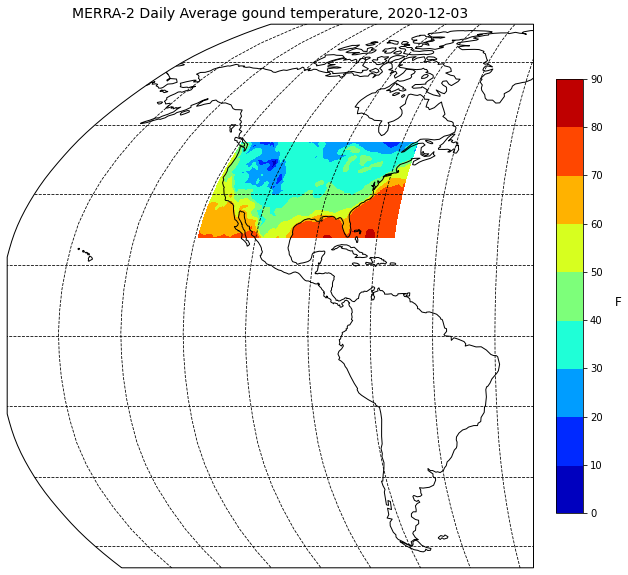

In [386]:
map_temp()